In [1]:
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Subset

from flight.federation.topologies.node import NodeKind
from flight.federation.topologies import Topology
from flight.federation.topologies.utils import flat_topology, hierarchical_topology, balanced_topology, balanced_topology_by_leaves

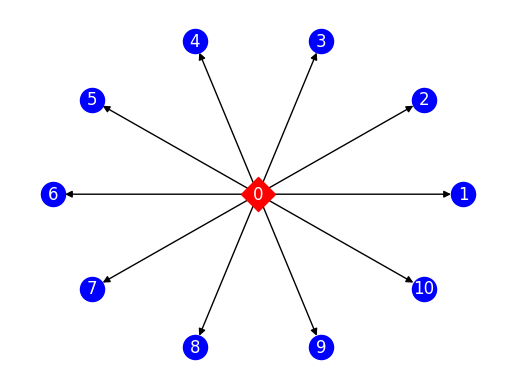

In [2]:
topo = flat_topology(10)
topo.draw(prog="circo")
plt.show()

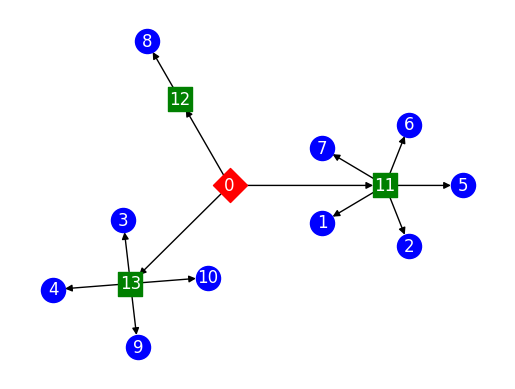

In [3]:
topo = hierarchical_topology(10, (3,), rng=1)
topo.draw(prog="circo")
plt.show()

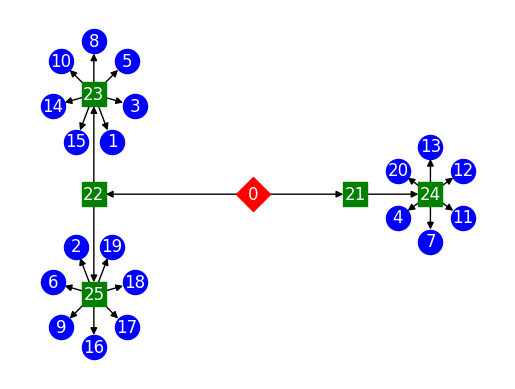

In [4]:
topo = hierarchical_topology(20, (2, 3,), rng=1)
topo.draw(prog="circo")
plt.show()

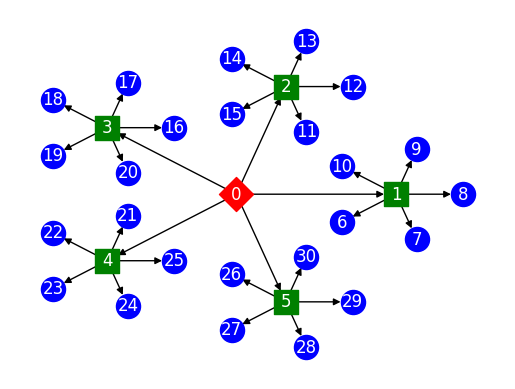

In [5]:
topo = balanced_topology(5, 2)
topo.draw(prog="circo")
plt.show()

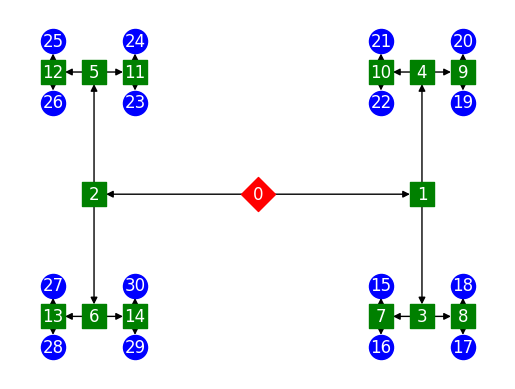

In [6]:
topo = balanced_topology_by_leaves(16, 4)
topo.draw(prog="circo")
plt.show()

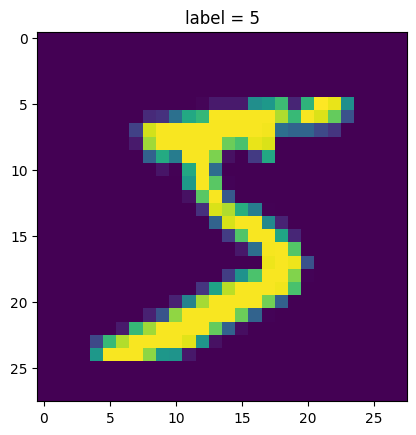

In [7]:
from torchvision.datasets import MNIST
from torchvision import transforms

mnist = MNIST(root="~/Research/Data/Torch-Data/", transform=transforms.ToTensor())
plt.imshow(mnist[0][0].squeeze())
plt.title(f"label = {mnist[0][1]}")
plt.show()

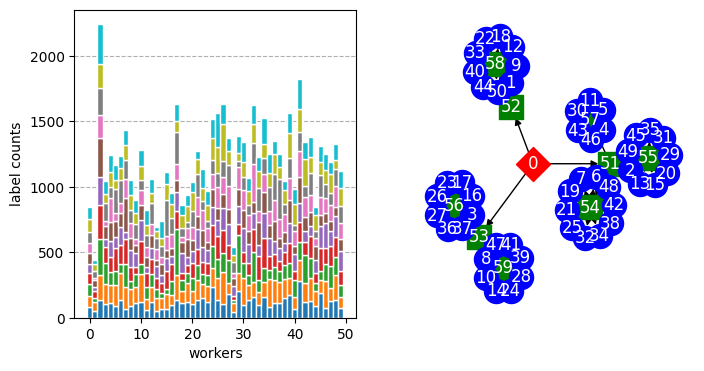

In [8]:
from flight.learning.torch.utils import fed_barplot, federated_split

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

topo = hierarchical_topology(50, (3, 6,), rng=1)
fed_data = federated_split(
    topo, 
    mnist,
    10,
    label_alpha=10.0,
    sample_alpha=10.0,
    rng=1,             
)
fed_barplot(fed_data, 10, width=1.0, edgecolor="white", ax=axes[0])
topo.draw(ax=axes[1], prog="circo")
axes[0].grid(True, axis="y", linestyle="--")
axes[0].set_axisbelow(True)
plt.show()

100%|██████████| 16/16 [00:02<00:00,  7.77it/s]

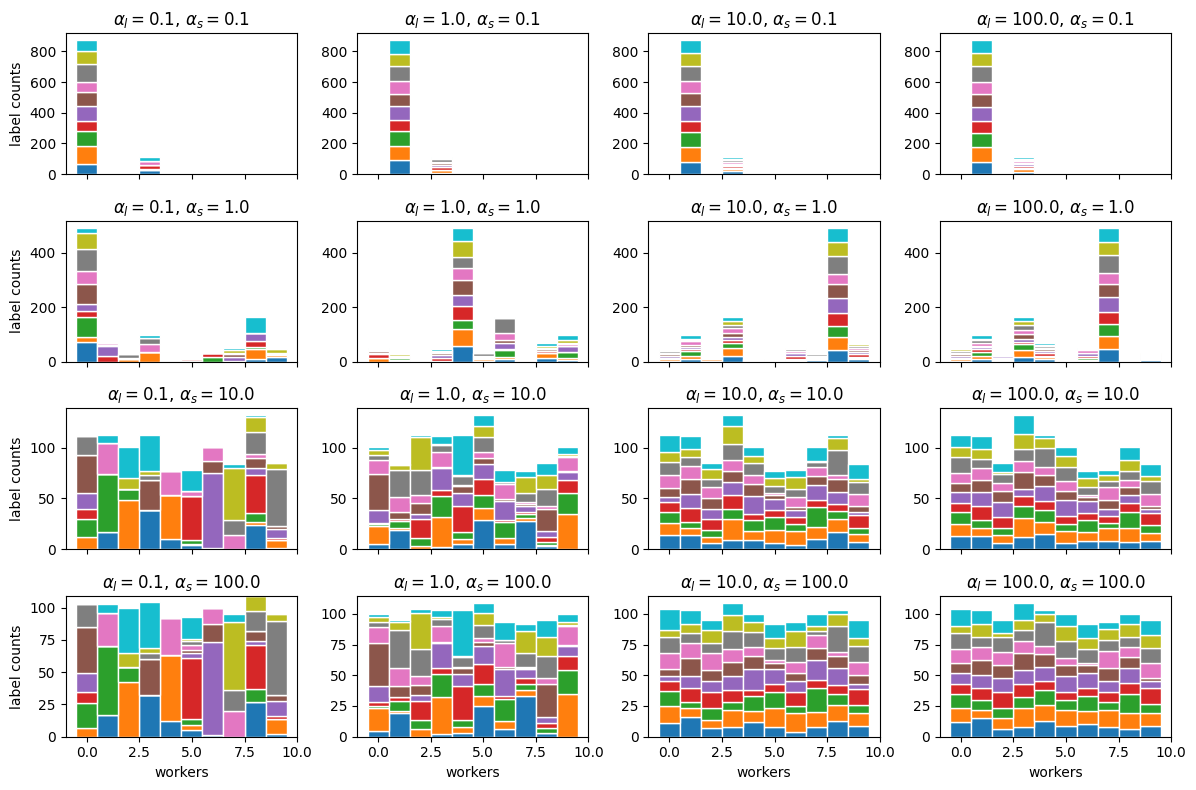

In [9]:
alphas = [0.1, 1.0, 10.0, 100.0]
figs, axes = plt.subplots(
    nrows=len(alphas),
    ncols=len(alphas),
    figsize=(12, 8),
    sharex=True,
    sharey=False,
)

topo = hierarchical_topology(10, (2, 3,), rng=1)
pbar = tqdm(total=len(alphas) ** 2)

for i, sa in enumerate(alphas):
    for j, la in enumerate(alphas):
        ax = axes[i, j]
        fed_data = federated_split(
            topo,
            Subset(mnist, list(range(1000))),
            10,
            label_alpha=la,
            sample_alpha=sa,
            rng=1,   
        )
        fed_barplot(fed_data, 10, width=1.0, edgecolor="white", ax=ax)
        ax.set_title(f"$\\alpha_l = {la:0.1f}$, $\\alpha_s = {sa:0.1f}$")
        pbar.update()

        if i != len(alphas) - 1:
            ax.set_xlabel("")

        if j != 0:
            ax.set_ylabel("")

plt.tight_layout()
plt.show()

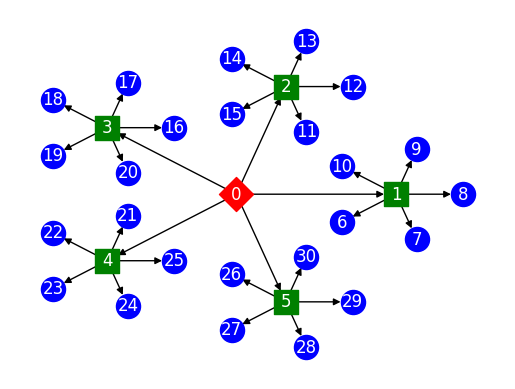

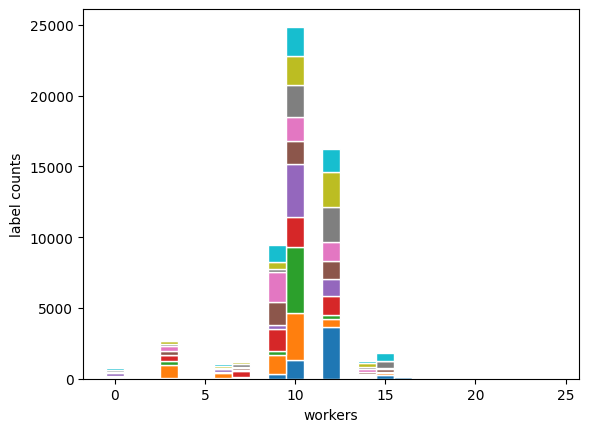

In [10]:
my_topo = balanced_topology(5, 2)
my_topo.draw(prog="circo")
plt.show()

fed_data = federated_split(my_topo, mnist, num_labels=10, label_alpha=1.0, sample_alpha=0.1, rng=1)
fed_barplot(fed_data, num_labels=10, width=1.0, edgecolor="white")
plt.show()

In [11]:
import torch
import torchmetrics

from flight.learning.torch import TorchModule
from torch import nn
from torch.nn import functional as F

class SmallConvModel(TorchModule):
    def __init__(self, lr: float = 0.01, device: str | None = None):
        super().__init__()
        self.lr = lr
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.last_accuracy = None

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self.forward(inputs)
        loss = F.cross_entropy(preds, targets)
        self.last_accuracy = self.accuracy(preds, targets)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.SGD(self.parameters(), lr=self.lr)

module = SmallConvModel()
module

SmallConvModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (accuracy): MulticlassAccuracy()
)

In [12]:
from flight.fit import federated_fit

results = federated_fit(
    my_topo,
    module,
    fed_data,
    rounds=5,
)
results.head()

NameError: name 'BaseTransfer' is not defined